In [1]:
import torch
import numpy as np
import os
import sys
import copy
import random
import csv
import pandas as pd
import scipy
from numpy import mean
#sys.path.append(os.path.abspath("C:\\Data\\Code\\BioML_refactor\\models"))
#sys.path.append(os.path.abspath("C:\\Data\\Code\\BioML_refactor\\utils"))
from boolODE_data_to_pyg_data import make_adj_from_df, to_pyg_data
from models.training import easyTrainer, weights_to_dataset, maskedTrainer
from models.nODE import nODE, make_nODE_from_parameters
import matplotlib.pyplot as plt
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')''

We load data, and take timepoint 0 as the initial condition for the ODE (x). Then, the full data matrix should be fitted using the ODE model (y)

In [2]:
datadir = './data/'
name = 'dyn_linear'
df=pd.read_csv(datadir + name + '/ExpressionData.csv', index_col=0)

adj_df = pd.read_csv(datadir + name + '/refNetwork.csv', index_col=0)

mat = df.to_numpy()

sz = df.to_numpy().shape
edge_index, adj = make_adj_from_df(datadir,df, name)
true_data = to_pyg_data(mat, sz[0], sz[1], edge_index=edge_index)

ode_dim = true_data.x.shape[0]

num_features = 3000

tp = []

with open(datadir + name + '/PseudoTime.csv') as f:
        reader = csv.reader(f)
        next(reader)
        for ln in reader:
            tp.append(float(ln[1]))

tp = torch.tensor(tp)

x = true_data.x[:,966] # linear
# x = true_data.x[:,2943] # bifurcating
y = true_data.x

# for later clarity, the time steps are ordered here
tp, indices = torch.sort(tp, 0)
y = y[:,indices]

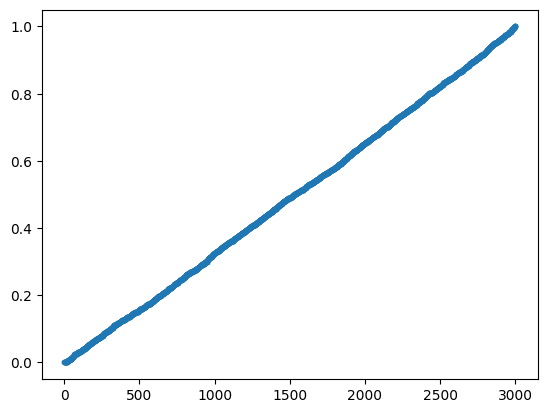

In [3]:
plt.plot(tp,'.')

Text(0.5, 1.0, 'here you really see stochasticity at play')

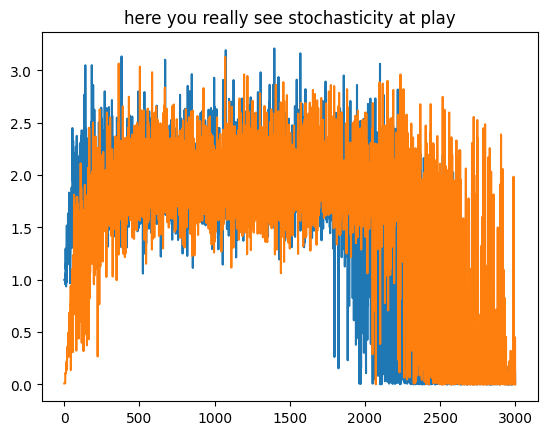

In [4]:
plt.plot(y[0,:])
plt.plot(y[1,:])
plt.title('here you really see stochasticity at play')

$We remove 2 connections from the network. This allows us to compare a model that works from a model that does not work (should be replaced by actual GAE results later)

In [5]:
# generate imputed data where some edges are missing
p = 0.1
rem = []
while len(rem) != 1:
    rem = []
    imputed_edge_index = true_data.edge_index
    while len(rem) == 0:
        for k in range(0,len(true_data.edge_index[0])):
            if random.random() < p:
                rem.append(k)

mask = torch.ones(imputed_edge_index.shape[1], dtype=torch.bool)
mask[rem] = False

imputed_edge_index = imputed_edge_index[:,mask]

# data has MOST edges
data = copy.deepcopy(true_data)
data.edge_index = imputed_edge_index

Get masks for true network and imputed network

In [6]:
ode_dim = true_data.x.shape[0]
mask_true = torch.zeros((ode_dim,ode_dim))
mask_incorrect = torch.zeros((ode_dim,ode_dim))

true_e = true_data.edge_index
e = data.edge_index

for k in range(0,len(true_e[0])):
    mask_true[true_e[0][k],true_e[1][k]] = 1

for k in range(0,len(e[0])):
    mask_incorrect[e[0][k],e[1][k]] = 1

In [7]:
class tsTrainer():
    def __init__(self, model, optimizer, device, x0, y, tp, mask,
                 print_freq=10, record_freq=10, verbose=1, save_dir=None,
                 l2_factor=0, db_type='l1'):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.loss_func = torch.nn.MSELoss()
        self.print_freq = print_freq
        self.record_freq = record_freq
        self.steps = 0
        self.save_dir = save_dir
        self.verbose = verbose
        self.x0 = x0
        self.y = y
        self.tp = tp
        self.mask = mask

        self.histories = {'loss_history': [],
                          'epoch_loss_history': []}
        self.buffer = {'loss': []}
        self.is_resnet = (type(self.model).__name__ == 'resnet')
        self.is_nODE = (type(self.model).__name__ == 'nODE')
        self.l2_factor = l2_factor
        self.db_type = db_type

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            avg_loss = self._train_epoch()
            if self.verbose:
                print("Epoch {}: {:.3f}".format(epoch + 1, avg_loss))         
            
    def _train_epoch(self):
        loss = 0.

        # y_pred = self.model(self.x0, return_features=True)
        # sim_time = torch.linspace(0, 1, 300)

        ref = self.model(self.x0, return_features=True, time_intervals=self.tp)
        # # Classical empirical risk minimization
        
        loss = self.loss_func(ref, y)

        l1_loss = torch.abs(self.model.inside_weights.weight)[self.mask == 0].sum()

        #loss = loss + 1000*l1_loss

        loss.backward()
        self.optimizer.step()

        # epoch_loss += loss.item()

        self.buffer['loss'].append(loss.item())

        # At every record_freq iteration, record mean loss and clear buffer
        if self.steps % self.record_freq == 0:
            self.histories['loss_history'].append(mean(self.buffer['loss']))

            # Clear buffer
            self.buffer['loss'] = []

        self.steps += 1

        return loss.item()

In [8]:
x

tensor([1.0000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100])

In [9]:
tp

tensor([0., 0., 0.,  ..., 1., 1., 1.])

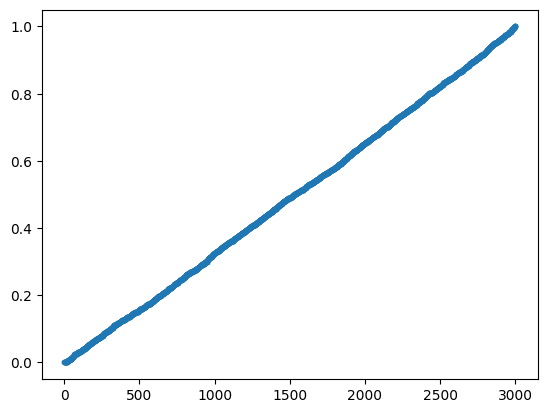

In [10]:
plt.plot(tp,'.')

In [13]:
tp[0] - tp[1]

tensor(0.)

In [11]:
node = nODE(ode_dim, architecture='both', time_interval=[0, 1])

optimizer_node = torch.optim.Adam(node.parameters(), lr=0.0001)

trainer = tsTrainer(node, optimizer_node, device, x, y, tp, mask_incorrect, verbose=1)
print()
print(y.shape[1])
trainer.train(10000)


3000


/Users/queirolo/Desktop/GIT_repository/BioML/models/nODE.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  integration_interval = torch.tensor(time_intervals).float().type_as(x)


AssertionError: t must be strictly increasing or decreasing

In [ ]:
node.inside_weights.weight
node.outside_weights.weight
print(torch.matmul(node.outside_weights.weight, node.inside_weights.weight))
print(mask_incorrect)

tensor([[-0.0343,  0.0008, -0.0226,  0.0245,  0.0042, -0.0239,  0.0053],
        [ 0.0122,  0.0027,  0.0021,  0.0140,  0.0197,  0.0272,  0.0117],
        [-0.0172,  0.0345, -0.0331,  0.0104, -0.0187, -0.0123, -0.0325],
        [ 0.0219, -0.0053,  0.0080,  0.0236,  0.0231, -0.0155,  0.0053],
        [-0.0521,  0.0064, -0.0431,  0.0272, -0.0238, -0.0066, -0.0107],
        [-0.0288,  0.0093, -0.0129,  0.0222, -0.0046, -0.0153, -0.0118],
        [ 0.0196, -0.0262,  0.0420, -0.0139, -0.0045,  0.0566,  0.0078]],
       grad_fn=<MmBackward0>)
tensor([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1.]])
